# Training an CNN image classifier 
For the purposes of our semestral project we chose [Animal Faces](https://www.kaggle.com/andrewmvd/animal-faces) dataset from kaggle. Dataset contains images of animals belonging to 3 classes - cat, dog and wild.

In [43]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Softmax
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.losses import SparseCategoricalCrossentropy
import keras
import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint

## Loading images using keras.preprocessing
Directory structure:

data
* train/
  * cat/
  * dog/
  * wild/
* test/
  * cat/
  * dog/
  * wild/

In [44]:
DATA = 'data/train'
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128

In [45]:
def create_basic_datagen():
    return ImageDataGenerator(
        validation_split=VALIDATION_SPLIT)

def create_advanced_datagen():
    return ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        brightness_range=[0.9, 1.1],
        rotation_range=30,
        shear_range=0.2,
        validation_split=VALIDATION_SPLIT)

def create_flow(datagen, subset, directory, advanced=False):
    return datagen.flow_from_directory(
        directory = directory,
        target_size= (128, 128) if advanced else (512, 512),
        color_mode = 'rgb',
        batch_size = BATCH_SIZE,
        class_mode = 'categorical',
        subset = subset,
        shuffle = True
    )

In [46]:
dg = create_basic_datagen()
train_gen = create_flow(dg, 'training', DATA)
val_gen = create_flow(dg, 'validation', DATA)

Found 11706 images belonging to 3 classes.
Found 2924 images belonging to 3 classes.


## Loading verification
Let's see the results by displaying some images.

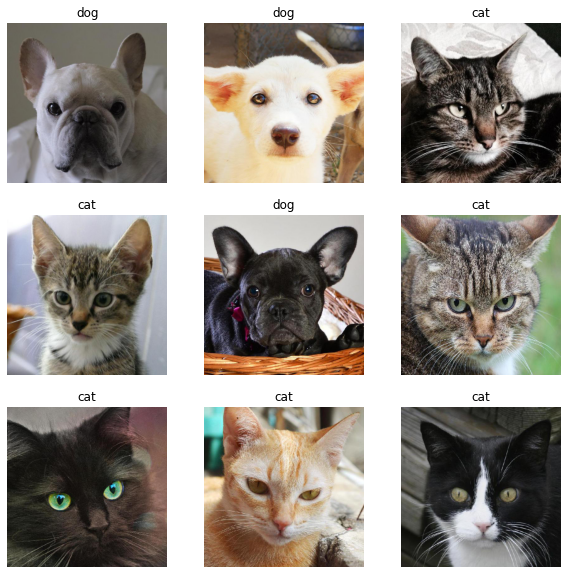

In [47]:
classes = ['cat', 'dog', 'wild']
plt.figure(figsize=(10, 10))
images, labels = train_gen.next()
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype(int))
    for j, label in enumerate(labels[i]):
        if label == 1:
            plt.title(classes[j])
            break
    plt.axis("off")

Images are looking great, but the neural network that was trained on them was overfitted.

To overcome this problem we tried to minimize the number of features (by reducing image size) and provided different image rotations, brightnesses and so on. This process is called Image Augmentation and it is mostly used when the training dataset is small. That is not our case, but it helped us to prevent overfitting. Image augmentation is implemented in function *create_advanced_datagen*.

In [48]:
dg = create_advanced_datagen()
train_gen = create_flow(dg, 'training', DATA, True)
val_gen = create_flow(dg, 'validation', DATA, True)

Found 11706 images belonging to 3 classes.
Found 2924 images belonging to 3 classes.


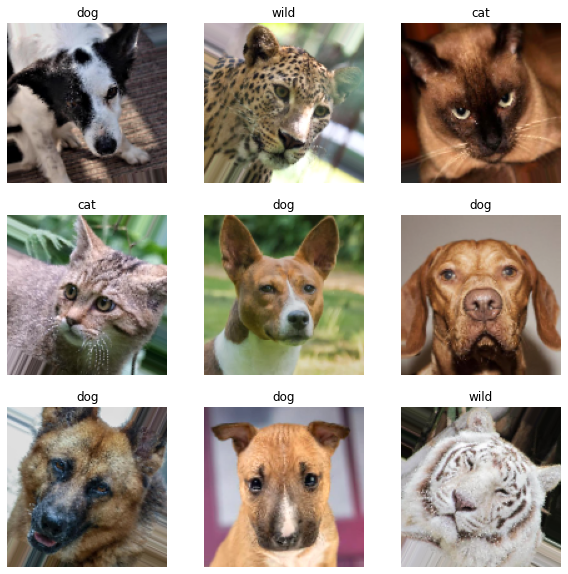

In [49]:
classes = ['cat', 'dog', 'wild']
plt.figure(figsize=(10, 10))
images, labels = train_gen.next()
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    for j, label in enumerate(labels[i]):
        if label == 1:
            plt.title(classes[j])
            break
    plt.axis("off")

## Training phase
Our architecture is quite standard. We used two blocks of Convolutional layer followed by Pooling layer. Then we used Flatten layer so that the output of our network matched the target value dimensions. After that followed Fully connected layer with Dropout layer to prevent overfitting. Softmax was used as last layer because we wanted our network to output probability that image belongs to each of the classes.

In [50]:
num_classes = 3

model = Sequential([
  Conv2D(32, 5, activation='relu', input_shape=(128, 128, 3)),
  MaxPooling2D(),
  Conv2D(32, 5, activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dropout(0.15),
  Dense(num_classes),
  Softmax()
])

In [51]:
model.compile(
  optimizer = 'adam',
  loss = 'categorical_crossentropy',
  metrics = ['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 124, 124, 32)      2432      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 58, 58, 32)        25632     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 29, 29, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 26912)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               3444864   
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

We used two callbacks during training phase. The first one is **EarlyStopping**. This callback stops the training if our network doesn't improve on validation accuracy 3 epochs in a row.

This is a little unfortunate because it means that the final model wont be as good as it was 3 epochs ago. To overcome this problem we used second callback - **ModelCheckpoint**. This callback saves the model every time its validation accuracy improves.

In [52]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3)
mc = ModelCheckpoint('best_model', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

epochs = 30
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs = epochs,
    callbacks=[es, mc]
)

Epoch 1/30
92/92 [==============================] - 106s 1s/step - loss: 0.8323 - accuracy: 0.6282 - val_loss: 0.4435 - val_accuracy: 0.7818

Epoch 00001: val_accuracy improved from -inf to 0.78181, saving model to best_model
Epoch 2/30
92/92 [==============================] - 102s 1s/step - loss: 0.4339 - accuracy: 0.8313 - val_loss: 0.6007 - val_accuracy: 0.8252

Epoch 00002: val_accuracy improved from 0.78181 to 0.82524, saving model to best_model
Epoch 3/30
92/92 [==============================] - 101s 1s/step - loss: 0.3463 - accuracy: 0.8698 - val_loss: 0.3414 - val_accuracy: 0.8642

Epoch 00003: val_accuracy improved from 0.82524 to 0.86423, saving model to best_model
Epoch 4/30
92/92 [==============================] - 101s 1s/step - loss: 0.2502 - accuracy: 0.9053 - val_loss: 0.3215 - val_accuracy: 0.8902

Epoch 00004: val_accuracy improved from 0.86423 to 0.89022, saving model to best_model
Epoch 5/30
92/92 [==============================] - 101s 1s/step - loss: 0.2164 - accur

## Visualization of training process
To see training history in more compact way, we constructed a graph that shows development of training and validation accuracy and loss over time. The red line highlights the epoch at which the model was saved. As we can see, our model is not overfitting anymore.

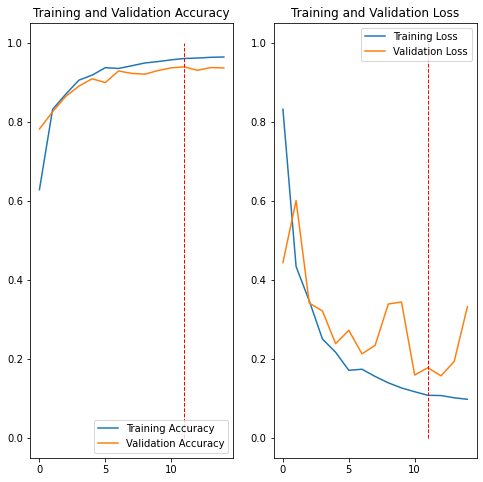

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot([11, 11], [0, 1], 'r--', lw=1)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.plot([11, 11], [0, 1], 'r--', lw=1)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Where to next
We used ModelCheckpoint callback during training phase to save the best performing model to *best_model* file. Further evaluation of this model on the test set was performed in *classifier_evaluation.ipynb*.